<a href="https://colab.research.google.com/github/mohamedalaaaz/testpytroch/blob/main/Projectile%20Motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0 | Loss: 293.214050
Epoch 500 | Loss: 13.279363
Epoch 1000 | Loss: 0.809386
Epoch 1500 | Loss: 0.027646
Epoch 2000 | Loss: 0.005531
Epoch 2500 | Loss: 0.004994
Epoch 3000 | Loss: 0.000777
Epoch 3500 | Loss: 0.009746
Epoch 4000 | Loss: 0.000387
Epoch 4500 | Loss: 0.000556


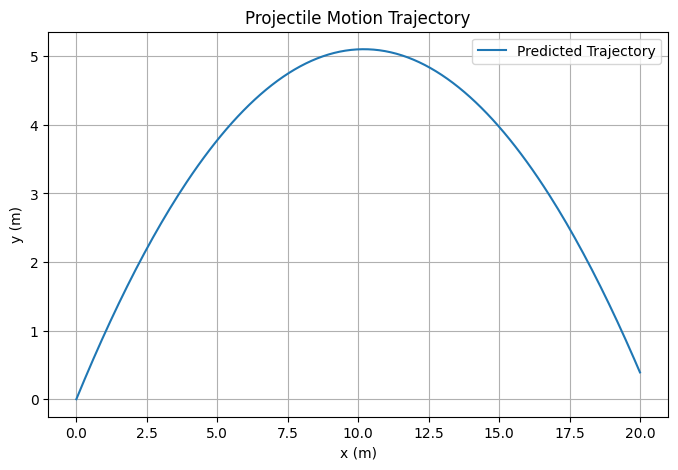

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity

class ProjectileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # outputs: [x(t), y(t)]
        )

    def forward(self, t):
        return self.net(t)

def physics_loss(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # 2nd derivatives
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]

    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]

    # Physics residuals: accelerations
    loss_phys = torch.mean(x_tt**2) + torch.mean((y_tt + g)**2)

    # Initial conditions: position and velocity at t=0
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0 = output0[:, 0:1]
    y0 = output0[:, 1:2]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]

    loss_ic = (x0**2) + (y0**2)  # position at t=0 should be zero
    loss_ic += (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2  # velocity at t=0 = v0

    return loss_phys + loss_ic

# Training
def train(model, epochs=5000, lr=1e-3, v0=torch.tensor([10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 2, 100, device=device).view(-1,1)
        loss = physics_loss(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model = ProjectileNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0], device=device)  # m/s
train(model, v0=initial_velocity)

# Plot results
t_test = torch.linspace(0, 2, 200, device=device).view(-1, 1)
with torch.no_grad():
    traj = model(t_test).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(traj[:, 0], traj[:, 1], label="Predicted Trajectory")
plt.title("Projectile Motion Trajectory")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.legend()
plt.show()


Epoch 0 | Loss: 289.549164
Epoch 500 | Loss: 33.365173
Epoch 1000 | Loss: 13.040833
Epoch 1500 | Loss: 3.172204
Epoch 2000 | Loss: 0.452612
Epoch 2500 | Loss: 0.058741
Epoch 3000 | Loss: 0.008808
Epoch 3500 | Loss: 0.004654
Epoch 4000 | Loss: 0.002129
Epoch 4500 | Loss: 0.003549
Epoch 5000 | Loss: 0.002520
Epoch 5500 | Loss: 0.001612
Epoch 6000 | Loss: 0.001159
Epoch 6500 | Loss: 0.000537


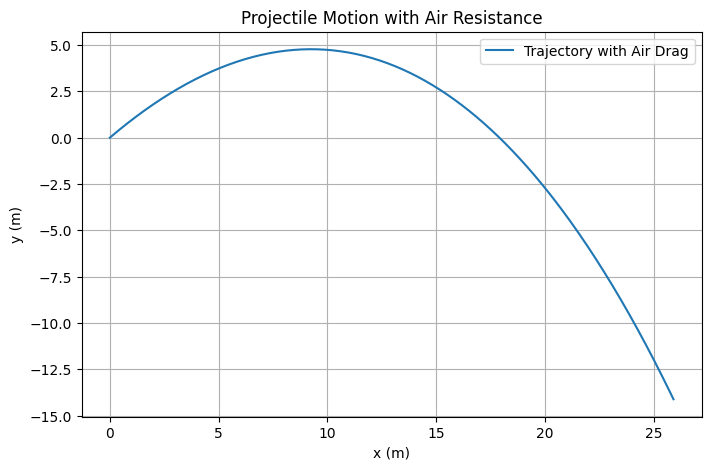

In [2]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity
k = 0.1   # drag coefficient

class ProjectileDragNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # outputs: [x(t), y(t)]
        )

    def forward(self, t):
        return self.net(t)

def physics_loss_drag(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # First derivatives (velocity)
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]

    # Second derivatives (acceleration)
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]

    # Physics residuals with drag
    loss_phys = torch.mean((x_tt + k * x_t)**2) + torch.mean((y_tt + g + k * y_t)**2)

    # Initial conditions: position and velocity at t=0
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0 = output0[:, 0:1]
    y0 = output0[:, 1:2]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]

    loss_ic = (x0**2) + (y0**2)  # position zero at t=0
    loss_ic += (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2  # velocity at t=0 = v0

    return loss_phys + loss_ic

def train_drag(model, epochs=7000, lr=1e-3, v0=torch.tensor([10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_drag(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_drag = ProjectileDragNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0], device=device)  # m/s
train_drag(model_drag, v0=initial_velocity)

# Plot results
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_drag(t_test).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(traj[:, 0], traj[:, 1], label="Trajectory with Air Drag")
plt.title("Projectile Motion with Air Resistance")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.legend()
plt.show()


Epoch 0 | Loss: 299.635925
Epoch 500 | Loss: 38.767536
Epoch 1000 | Loss: 16.894779
Epoch 1500 | Loss: 3.807546
Epoch 2000 | Loss: 0.449620
Epoch 2500 | Loss: 0.042557
Epoch 3000 | Loss: 0.005523
Epoch 3500 | Loss: 0.017941
Epoch 4000 | Loss: 0.003876
Epoch 4500 | Loss: 0.000897
Epoch 5000 | Loss: 0.005910
Epoch 5500 | Loss: 0.004194
Epoch 6000 | Loss: 0.001542
Epoch 6500 | Loss: 0.042052


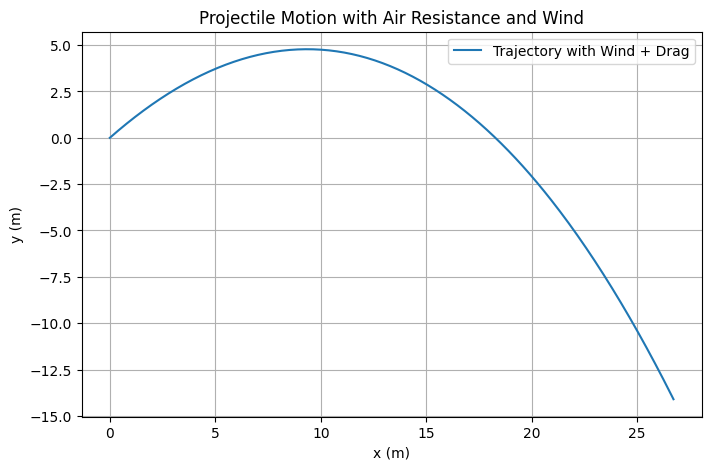

In [3]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity
k = 0.1   # drag coefficient

class ProjectileWindNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # outputs: [x(t), y(t)]
        )

    def forward(self, t):
        return self.net(t)

def physics_loss_wind(model, t, v0, wind):
    t.requires_grad_(True)
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Velocity
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]

    # Acceleration
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]

    # Residuals with wind-modified drag
    loss_phys = torch.mean((x_tt + k * (x_t - wind[0]))**2) + torch.mean((y_tt + g + k * (y_t - wind[1]))**2)

    # Initial conditions: position & velocity at t=0
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0 = output0[:, 0:1]
    y0 = output0[:, 1:2]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]

    loss_ic = (x0**2) + (y0**2)  # initial position at origin
    loss_ic += (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2  # initial velocity

    return loss_phys + loss_ic

def train_wind(model, epochs=7000, lr=1e-3, v0=torch.tensor([10.0, 10.0], device=device), wind=torch.tensor([2.0, 0.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_wind(model, t, v0, wind)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_wind = ProjectileWindNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0], device=device)  # m/s
wind_velocity = torch.tensor([2.0, 0.0], device=device)        # wind blowing right at 2 m/s
train_wind(model_wind, v0=initial_velocity, wind=wind_velocity)

# Plot results
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_wind(t_test).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(traj[:, 0], traj[:, 1], label="Trajectory with Wind + Drag")
plt.title("Projectile Motion with Air Resistance and Wind")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.legend()
plt.show()


Epoch 0 | Loss: 386.997253
Epoch 500 | Loss: 14.599416
Epoch 1000 | Loss: 0.578818
Epoch 1500 | Loss: 0.019458
Epoch 2000 | Loss: 0.002667
Epoch 2500 | Loss: 0.008762
Epoch 3000 | Loss: 0.013294
Epoch 3500 | Loss: 0.000622
Epoch 4000 | Loss: 0.001997
Epoch 4500 | Loss: 0.009114
Epoch 5000 | Loss: 0.001871
Epoch 5500 | Loss: 0.030906
Epoch 6000 | Loss: 0.114259
Epoch 6500 | Loss: 0.025017
Epoch 7000 | Loss: 0.013654
Epoch 7500 | Loss: 0.000368


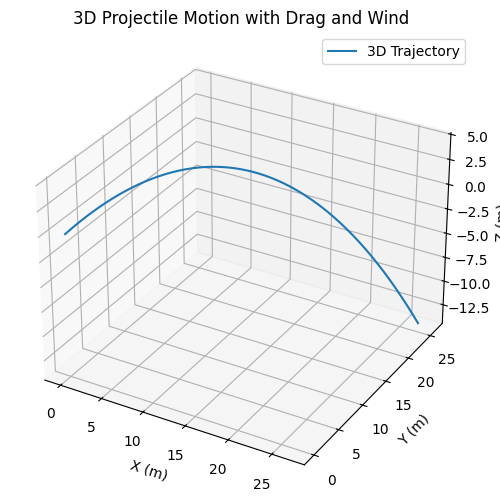

In [4]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81
k = 0.1

class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # Outputs: [x(t), y(t), z(t)]
        )

    def forward(self, t):
        return self.net(t)

def physics_loss_3d(model, t, v0, wind):
    t.requires_grad_(True)
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]
    z = output[:, 2:3]

    # First derivatives (velocities)
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    # Second derivatives (accelerations)
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    # Residuals with drag and wind
    loss_phys = torch.mean((x_tt + k*(x_t - wind[0]))**2) + \
                torch.mean((y_tt + k*(y_t - wind[1]))**2) + \
                torch.mean((z_tt + g + k*(z_t - wind[2]))**2)

    # Initial conditions at t=0
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0 = output0[:, 0:1]
    y0 = output0[:, 1:2]
    z0 = output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic

def train_3d(model, epochs=8000, lr=1e-3, v0=torch.tensor([10.0, 10.0, 10.0], device=device), wind=torch.tensor([2.0, 0.0, 0.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_3d(model, t, v0, wind)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_3d = Projectile3DNet().to(device)
initial_velocity_3d = torch.tensor([10.0, 10.0, 10.0], device=device)  # m/s
wind_velocity_3d = torch.tensor([2.0, 0.0, 0.0], device=device)       # wind in x-direction
train_3d(model_3d, v0=initial_velocity_3d, wind=wind_velocity_3d)

# Plot 3D trajectory
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_3d(t_test).cpu().numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='3D Trajectory')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Projectile Motion with Drag and Wind')
ax.legend()
plt.show()


In [5]:
def wind_func(t):
    # Example: wind oscillates in x-direction with time
    return torch.cat([
        2.0 * torch.sin(2 * 3.1415 * t),  # v_wx(t)
        0.5 * torch.cos(2 * 3.1415 * t),  # v_wy(t)
        torch.zeros_like(t)                # v_wz(t)
    ], dim=1)

def drag_func(t):
    # Example: drag increases linearly with time
    return 0.05 + 0.05 * t.squeeze()

def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]
    z = output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)
    v_w = wind_func(t)
    k_t = drag_func(t).unsqueeze(1)

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    a = torch.cat([x_tt, y_tt, z_tt], dim=1)

    gravity = torch.tensor([0, 0, g], device=device).unsqueeze(0)

    # Physics residual: a + gravity + k(t)*(v - v_w(t)) = 0
    residual = a + gravity + k_t * (v - v_w)

    loss_phys = torch.mean(residual**2)

    # Initial conditions (same as before)
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0, y0, z0 = output0[:, 0:1], output0[:, 1:2], output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic


Epoch 0 | Loss: 297.950592
Epoch 500 | Loss: 52.033123
Epoch 1000 | Loss: 21.098341
Epoch 1500 | Loss: 5.509968
Epoch 2000 | Loss: 0.769531
Epoch 2500 | Loss: 0.066459
Epoch 3000 | Loss: 0.008235
Epoch 3500 | Loss: 0.010733
Epoch 4000 | Loss: 0.002624
Epoch 4500 | Loss: 0.005576
Epoch 5000 | Loss: 0.032103
Epoch 5500 | Loss: 0.001094
Epoch 6000 | Loss: 0.000632
Epoch 6500 | Loss: 0.002485


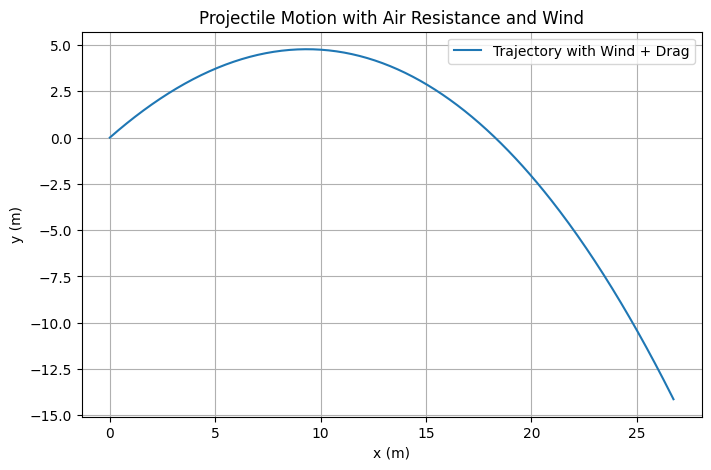

In [6]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity
k = 0.1   # drag coefficient

class ProjectileWindNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # outputs: [x(t), y(t)]
        )

    def forward(self, t):
        return self.net(t)

def physics_loss_wind(model, t, v0, wind):
    t.requires_grad_(True)
    output = model(t)
    x = output[:, 0:1]
    y = output[:, 1:2]

    # Velocity
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]

    # Acceleration
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]

    # Residuals with wind-modified drag
    loss_phys = torch.mean((x_tt + k * (x_t - wind[0]))**2) + torch.mean((y_tt + g + k * (y_t - wind[1]))**2)

    # Initial conditions: position & velocity at t=0
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0 = output0[:, 0:1]
    y0 = output0[:, 1:2]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]

    loss_ic = (x0**2) + (y0**2)  # initial position at origin
    loss_ic += (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2  # initial velocity

    return loss_phys + loss_ic

def train_wind(model, epochs=7000, lr=1e-3, v0=torch.tensor([10.0, 10.0], device=device), wind=torch.tensor([2.0, 0.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_wind(model, t, v0, wind)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_wind = ProjectileWindNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0], device=device)  # m/s
wind_velocity = torch.tensor([2.0, 0.0], device=device)        # wind blowing right at 2 m/s
train_wind(model_wind, v0=initial_velocity, wind=wind_velocity)

# Plot results
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_wind(t_test).cpu().numpy()

plt.figure(figsize=(8,5))
plt.plot(traj[:, 0], traj[:, 1], label="Trajectory with Wind + Drag")
plt.title("Projectile Motion with Air Resistance and Wind")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.grid()
plt.legend()
plt.show()


Epoch 0 | Loss: 324.909943
Epoch 500 | Loss: 11.762381
Epoch 1000 | Loss: 2.329785
Epoch 1500 | Loss: 0.169544
Epoch 2000 | Loss: 0.008713
Epoch 2500 | Loss: 0.008793
Epoch 3000 | Loss: 0.004173
Epoch 3500 | Loss: 0.000567
Epoch 4000 | Loss: 0.000491
Epoch 4500 | Loss: 0.000376
Epoch 5000 | Loss: 0.015174
Epoch 5500 | Loss: 0.028262
Epoch 6000 | Loss: 0.040906
Epoch 6500 | Loss: 0.000639
Epoch 7000 | Loss: 0.000070
Epoch 7500 | Loss: 0.001192


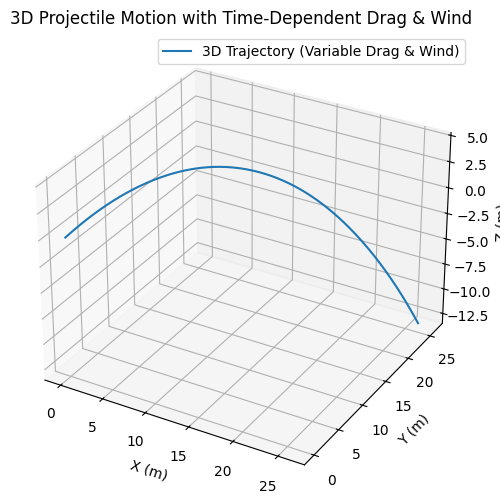

In [7]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity

# Neural network for 3D trajectory
class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # x, y, z outputs
        )
    def forward(self, t):
        return self.net(t)

# Time-dependent wind velocity function
def wind_func(t):
    # t shape: (N, 1)
    return torch.cat([
        2.0 * torch.sin(2 * 3.1415 * t),   # v_wx(t)
        0.5 * torch.cos(2 * 3.1415 * t),   # v_wy(t)
        torch.zeros_like(t)                 # v_wz(t)
    ], dim=1)

# Time-dependent drag coefficient
def drag_func(t):
    # Linear increase from 0.05 to 0.1 over t in [0,3]
    return 0.05 + 0.05 * t.squeeze()

# Physics-informed loss with variable drag and wind
def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x, y, z = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)
    v_w = wind_func(t)
    k_t = drag_func(t).unsqueeze(1)

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    a = torch.cat([x_tt, y_tt, z_tt], dim=1)

    gravity = torch.tensor([0, 0, g], device=device).unsqueeze(0)

    residual = a + gravity + k_t * (v - v_w)

    loss_phys = torch.mean(residual**2)

    # Initial conditions at t=0
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0, y0, z0 = output0[:, 0:1], output0[:, 1:2], output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic

def train_variable(model, epochs=8000, lr=1e-3, v0=torch.tensor([10.0, 10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_variable(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_var = Projectile3DNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0, 10.0], device=device)  # m/s

train_variable(model_var, v0=initial_velocity)

# Plot 3D trajectory
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_var(t_test).cpu().numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='3D Trajectory (Variable Drag & Wind)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Projectile Motion with Time-Dependent Drag & Wind')
ax.legend()
plt.show()


Epoch 0 | Loss: 333.409821
Epoch 500 | Loss: 12.776403
Epoch 1000 | Loss: 2.938932
Epoch 1500 | Loss: 0.353105
Epoch 2000 | Loss: 0.084662
Epoch 2500 | Loss: 0.074236
Epoch 3000 | Loss: 0.074723
Epoch 3500 | Loss: 0.083015
Epoch 4000 | Loss: 0.149677
Epoch 4500 | Loss: 0.072902
Epoch 5000 | Loss: 0.073129
Epoch 5500 | Loss: 0.073399
Epoch 6000 | Loss: 0.072575
Epoch 6500 | Loss: 0.079502
Epoch 7000 | Loss: 0.072585
Epoch 7500 | Loss: 0.073320


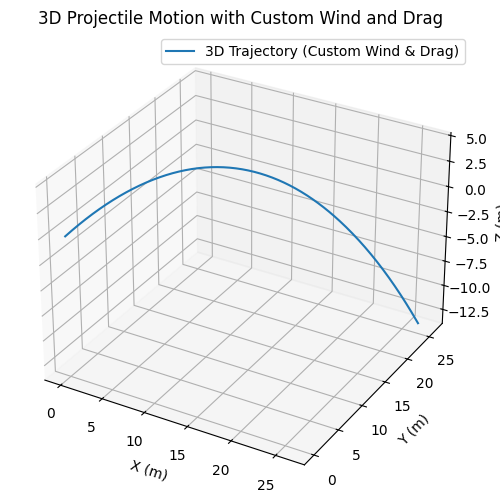

In [8]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity

# Neural network for 3D trajectory
class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # x, y, z outputs
        )
    def forward(self, t):
        return self.net(t)

# Wind function: Wind direction oscillates and varies with height
def wind_func(t, z):
    # Wind increases with height (z), and oscillates in x, y
    wind_x = 2.0 * torch.sin(2 * 3.1415 * t) + 0.05 * z
    wind_y = 0.5 * torch.cos(2 * 3.1415 * t) + 0.03 * z
    wind_z = 0.2 * torch.sin(2 * 3.1415 * t)  # No change in vertical wind for now
    return torch.cat([wind_x, wind_y, wind_z], dim=1)

# Drag coefficient function: Varies with velocity magnitude
def drag_func(v):
    # |v| = sqrt(vx^2 + vy^2 + vz^2)
    v_mag = torch.sqrt(torch.sum(v**2, dim=1, keepdim=True))  # Magnitude of velocity
    return 0.05 * v_mag  # Linear dependence on velocity magnitude

# Altitude-dependent drag: Higher drag at lower altitudes
def drag_func_alt(z):
    return 0.05 + 0.01 * torch.abs(z)  # Higher drag at lower altitudes

# Physics loss with time-dependent wind, drag, and altitude effects
def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x, y, z = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)

    # Wind and drag calculations
    wind = wind_func(t, z)
    k_t = drag_func(v)  # Drag depends on velocity magnitude
    k_z = drag_func_alt(z)  # Altitude-dependent drag

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    a = torch.cat([x_tt, y_tt, z_tt], dim=1)

    gravity = torch.tensor([0, 0, g], device=device).unsqueeze(0)

    # Physics residual: a + gravity + k(t)*(v - v_w(t)) = 0
    residual = a + gravity + k_z.unsqueeze(1) * (v - wind)

    loss_phys = torch.mean(residual**2)

    # Initial conditions (same as before)
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0, y0, z0 = output0[:, 0:1], output0[:, 1:2], output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic

def train_variable(model, epochs=8000, lr=1e-3, v0=torch.tensor([10.0, 10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_variable(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_var = Projectile3DNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0, 10.0], device=device)  # m/s

train_variable(model_var, v0=initial_velocity)

# Plot 3D trajectory
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_var(t_test).cpu().numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='3D Trajectory (Custom Wind & Drag)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Projectile Motion with Custom Wind and Drag')
ax.legend()
plt.show()


Epoch 0 | Loss: 334.980835
Epoch 500 | Loss: 12.469204
Epoch 1000 | Loss: 2.716957
Epoch 1500 | Loss: 0.346094
Epoch 2000 | Loss: 0.107782
Epoch 2500 | Loss: 0.073932
Epoch 3000 | Loss: 0.086802
Epoch 3500 | Loss: 0.072902
Epoch 4000 | Loss: 0.073023
Epoch 4500 | Loss: 0.075692
Epoch 5000 | Loss: 0.114713
Epoch 5500 | Loss: 0.074812
Epoch 6000 | Loss: 0.073332
Epoch 6500 | Loss: 0.073011
Epoch 7000 | Loss: 0.074694
Epoch 7500 | Loss: 0.079222


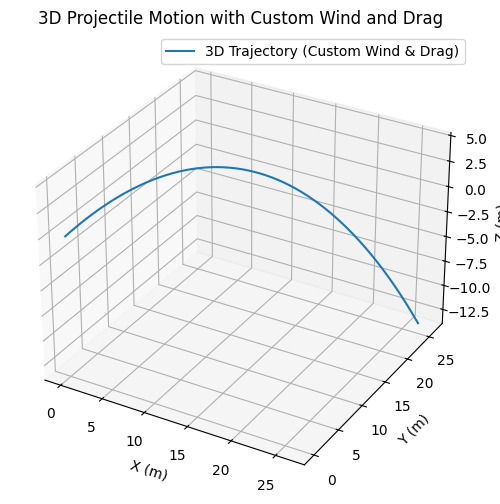

In [9]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity

# Neural network for 3D trajectory
class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # x, y, z outputs
        )
    def forward(self, t):
        return self.net(t)

# Wind function: Wind direction oscillates and varies with height
def wind_func(t, z):
    # Wind increases with height (z), and oscillates in x, y
    wind_x = 2.0 * torch.sin(2 * 3.1415 * t) + 0.05 * z
    wind_y = 0.5 * torch.cos(2 * 3.1415 * t) + 0.03 * z
    wind_z = 0.2 * torch.sin(2 * 3.1415 * t)  # No change in vertical wind for now
    return torch.cat([wind_x, wind_y, wind_z], dim=1)

# Drag coefficient function: Varies with velocity magnitude
def drag_func(v):
    # |v| = sqrt(vx^2 + vy^2 + vz^2)
    v_mag = torch.sqrt(torch.sum(v**2, dim=1, keepdim=True))  # Magnitude of velocity
    return 0.05 * v_mag  # Linear dependence on velocity magnitude

# Altitude-dependent drag: Higher drag at lower altitudes
def drag_func_alt(z):
    return 0.05 + 0.01 * torch.abs(z)  # Higher drag at lower altitudes

# Physics loss with time-dependent wind, drag, and altitude effects
def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x, y, z = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)

    # Wind and drag calculations
    wind = wind_func(t, z)
    k_t = drag_func(v)  # Drag depends on velocity magnitude
    k_z = drag_func_alt(z)  # Altitude-dependent drag

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    a = torch.cat([x_tt, y_tt, z_tt], dim=1)

    gravity = torch.tensor([0, 0, g], device=device).unsqueeze(0)

    # Physics residual: a + gravity + k(t)*(v - v_w(t)) = 0
    residual = a + gravity + k_z.unsqueeze(1) * (v - wind)

    loss_phys = torch.mean(residual**2)

    # Initial conditions (same as before)
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0, y0, z0 = output0[:, 0:1], output0[:, 1:2], output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic

def train_variable(model, epochs=8000, lr=1e-3, v0=torch.tensor([10.0, 10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_variable(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_var = Projectile3DNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0, 10.0], device=device)  # m/s

train_variable(model_var, v0=initial_velocity)

# Plot 3D trajectory
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_var(t_test).cpu().numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='3D Trajectory (Custom Wind & Drag)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Projectile Motion with Custom Wind and Drag')
ax.legend()
plt.show()


In [10]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = 9.81  # gravity

# Neural network for 3D trajectory
class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # x, y, z outputs
        )
    def forward(self, t):
        return self.net(t)

# Wind function: Wind with gusts and height-dependent components
def wind_func(t, z):
    # Wind oscillations
    wind_x = 2.0 * torch.sin(2 * 3.1415 * t) + 0.05 * z
    wind_y = 0.5 * torch.cos(2 * 3.1415 * t) + 0.03 * z
    wind_z = 0.2 * torch.sin(2 * 3.1415 * t)  # No vertical wind change for now

    # Add random gusts: sharp, random wind increases at certain time intervals
    gust_time = torch.randint(0, 50, (t.shape[0],), device=device)  # Random gust times
    gust_strength = torch.randn(t.shape[0], device=device)  # Random gust magnitude
    gust_effect = gust_strength * (gust_time == 1).float()  # Apply gusts at certain times

    wind_x += gust_effect * 3.0  # Gust in x-direction
    wind_y += gust_effect * 1.5  # Gust in y-direction

    return torch.cat([wind_x, wind_y, wind_z], dim=1)

# Non-Linear Drag Coefficient: Quadratic drag model
def drag_func(v):
    # Drag proportional to the square of velocity
    v_mag = torch.sqrt(torch.sum(v**2, dim=1, keepdim=True))  # Magnitude of velocity
    return 0.01 * v_mag**2  # Quadratic dependence on velocity magnitude

# Temperature-Dependent Drag: Drag decreases with increasing temperature
def temperature_effect(t):
    # Arbitrary temperature function that decreases linearly over time
    return 300 - 0.5 * t.squeeze()

# Physics loss with gusty wind, quadratic drag, and temperature effects
def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x, y, z = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)

    # Wind and drag calculations
    wind = wind_func(t, z)
    k_t = drag_func(v)  # Quadratic drag based on velocity
    temperature = temperature_effect(t)  # Temperature function to modify drag
    k_temp = drag_func(v) / temperature  # Modify drag by temperature effect

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    a = torch.cat([x_tt, y_tt, z_tt], dim=1)

    gravity = torch.tensor([0, 0, g], device=device).unsqueeze(0)

    # Physics residual: a + gravity + k(t)*(v - v_w(t)) = 0
    residual = a + gravity + k_temp.unsqueeze(1) * (v - wind)

    loss_phys = torch.mean(residual**2)

    # Initial conditions (same as before)
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0, y0, z0 = output0[:, 0:1], output0[:, 1:2], output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic

def train_variable(model, epochs=8000, lr=1e-3, v0=torch.tensor([10.0, 10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_variable(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_var = Projectile3DNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0, 10.0], device=device)  # m/s

train_variable(model_var, v0=initial_velocity)

# Plot 3D trajectory
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_var(t_test).cpu().numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='3D Trajectory (Gusts, Temp-Drag, Quadratic Drag)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Projectile Motion with Custom Wind, Drag, and Temperature Effects')
ax.legend()
plt.show()


RuntimeError: output with shape [200, 1] doesn't match the broadcast shape [200, 200]

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g0 = 9.81  # gravity at sea level (m/s^2)

# Neural network for 3D trajectory
class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # x, y, z outputs
        )
    def forward(self, t):
        return self.net(t)

# Wind function: Wind with gusts, height-dependent, and turbulent components
def wind_func(t, z):
    # Wind oscillations
    wind_x = 2.0 * torch.sin(2 * 3.1415 * t) + 0.05 * z
    wind_y = 0.5 * torch.cos(2 * 3.1415 * t) + 0.03 * z
    wind_z = 0.2 * torch.sin(2 * 3.1415 * t)  # No vertical wind change for now

    # Add random turbulent noise to wind components to simulate turbulence
    noise_x = 0.1 * torch.randn_like(t, device=device)  # Turbulence in x
    noise_y = 0.05 * torch.randn_like(t, device=device)  # Turbulence in y
    noise_z = 0.03 * torch.randn_like(t, device=device)  # Turbulence in z

    wind_x += noise_x
    wind_y += noise_y
    wind_z += noise_z

    return torch.cat([wind_x, wind_y, wind_z], dim=1)

# Non-Linear Drag Coefficient: Quadratic drag model
def drag_func(v):
    # Drag proportional to the square of velocity
    v_mag = torch.sqrt(torch.sum(v**2, dim=1, keepdim=True))  # Magnitude of velocity
    return 0.01 * v_mag**2  # Quadratic dependence on velocity magnitude

# Temperature-dependent drag: Advanced atmospheric temperature profile
def temperature_effect(z):
    # Use lapse rate for temperature change with height
    # Standard lapse rate = -6.5°C per km in the lower atmosphere
    temp_sea_level = 288.15  # Sea level temp in Kelvin (15°C)
    lapse_rate = 0.0065  # Temperature decrease per meter
    temp_at_z = temp_sea_level - lapse_rate * z
    return temp_at_z

# Altitude-Dependent Gravity: Gravity decreases with height
def gravity_func(z):
    # Gravity decreases slightly with height (model g(h) = g0 / (1 + alpha h))
    alpha = 1e-5  # Small constant for height dependence
    return g0 / (1 + alpha * z)

# Physics loss with turbulent wind, quadratic drag, altitude-dependent gravity, and temperature effects
def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x, y, z = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)

    # Wind and drag calculations
    wind = wind_func(t, z)
    k_t = drag_func(v)  # Quadratic drag based on velocity
    temperature = temperature_effect(z)  # Temperature effect due to altitude
    k_temp = drag_func(v) / temperature  # Modify drag by temperature effect
    g = gravity_func(z)  # Gravity decreases with height

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]
    z_tt = autograd.grad(z_t, t, torch.ones_like(z_t), create_graph=True)[0]

    a = torch.cat([x_tt, y_tt, z_tt], dim=1)

    # Physics residual: a + gravity + k(t)*(v - v_w(t)) = 0
    residual = a + g.unsqueeze(1) + k_temp.unsqueeze(1) * (v - wind)

    loss_phys = torch.mean(residual**2)

    # Initial conditions (same as before)
    t0 = torch.tensor([[0.]], device=device, requires_grad=True)
    output0 = model(t0)
    x0, y0, z0 = output0[:, 0:1], output0[:, 1:2], output0[:, 2:3]

    x_t0 = autograd.grad(x0, t0, torch.ones_like(x0), create_graph=True)[0]
    y_t0 = autograd.grad(y0, t0, torch.ones_like(y0), create_graph=True)[0]
    z_t0 = autograd.grad(z0, t0, torch.ones_like(z0), create_graph=True)[0]

    loss_ic = (x0**2 + y0**2 + z0**2) + \
              (x_t0 - v0[0])**2 + (y_t0 - v0[1])**2 + (z_t0 - v0[2])**2

    return loss_phys + loss_ic

def train_variable(model, epochs=8000, lr=1e-3, v0=torch.tensor([10.0, 10.0, 10.0], device=device)):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        t = torch.linspace(0, 3, 200, device=device).view(-1, 1)
        loss = physics_loss_variable(model, t, v0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

# Instantiate and train
model_var = Projectile3DNet().to(device)
initial_velocity = torch.tensor([10.0, 10.0, 10.0], device=device)  # m/s

train_variable(model_var, v0=initial_velocity)

# Plot 3D trajectory
t_test = torch.linspace(0, 3, 300, device=device).view(-1, 1)
with torch.no_grad():
    traj = model_var(t_test).cpu().numpy()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label='3D Trajectory (Turbulent Winds, Temp-Drag, Alt-Gravity)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Projectile Motion with Custom Wind, Drag, Temperature & Gravity')
ax.legend()
plt.show()


In [11]:
def wind_func(t, z):
    # Wind oscillations, modified to introduce spatial correlation with height
    wind_x = 2.0 * torch.sin(2 * 3.1415 * t) + 0.05 * z
    wind_y = 0.5 * torch.cos(2 * 3.1415 * t) + 0.03 * z
    wind_z = 0.2 * torch.sin(2 * 3.1415 * t)

    # Turbulent noise based on height, turbulence increases with altitude
    noise_intensity = 0.1 * (1 + z / 5000)  # Noise intensity increases with height (altitude)
    noise_x = noise_intensity * torch.randn_like(t, device=device)
    noise_y = noise_intensity * torch.randn_like(t, device=device)
    noise_z = 0.03 * torch.randn_like(t, device=device)  # Vertical turbulence is usually less intense

    wind_x += noise_x
    wind_y += noise_y
    wind_z += noise_z

    return torch.cat([wind_x, wind_y, wind_z], dim=1)


In [12]:
def temperature_effect(z, t):
    # Seasonal temperature fluctuation: Use a sine wave to represent temperature change over time (months)
    season_temp_variation = 15 * torch.sin(2 * np.pi * t / 365)  # Simple yearly temperature cycle
    temp_sea_level = 288.15 + season_temp_variation  # Sea-level temp in Kelvin (15°C +/- variation)

    # Lapse rate for temperature change with height
    lapse_rate = 0.0065  # Standard lapse rate in K/m
    temp_at_z = temp_sea_level - lapse_rate * z  # Temperature decreases with altitude
    return temp_at_z


In [13]:
def gravity_func(z):
    # Altitude-dependent gravity: Gravity decreases with height
    alpha = 1e-5  # Small constant for height dependence
    gravity = g0 / (1 + alpha * z)  # Gravity decreases with height

    # Simulating local anomalies (e.g., from mountains, Earth's rotation)
    anomaly_strength = 0.001  # Small anomaly factor
    gravity += anomaly_strength * torch.randn_like(z)  # Introduce small random variations in gravity

    return gravity


In [14]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g0 = 9.81  # gravity at sea level (m/s^2)

# Neural network for 3D trajectory
class Projectile3DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # x, y, z outputs
        )
    def forward(self, t):
        return self.net(t)

# Wind function with turbulence intensity, seasonal wind, and random gusts
def wind_func(t, z):
    # Wind oscillations, modified to introduce spatial correlation with height
    wind_x = 2.0 * torch.sin(2 * 3.1415 * t) + 0.05 * z
    wind_y = 0.5 * torch.cos(2 * 3.1415 * t) + 0.03 * z
    wind_z = 0.2 * torch.sin(2 * 3.1415 * t)

    # Turbulent noise based on height, turbulence increases with altitude
    noise_intensity = 0.1 * (1 + z / 5000)  # Noise intensity increases with height (altitude)
    noise_x = noise_intensity * torch.randn_like(t, device=device)
    noise_y = noise_intensity * torch.randn_like(t, device=device)
    noise_z = 0.03 * torch.randn_like(t, device=device)  # Vertical turbulence is usually less intense

    wind_x += noise_x
    wind_y += noise_y
    wind_z += noise_z

    return torch.cat([wind_x, wind_y, wind_z], dim=1)

# Non-Linear Drag Coefficient: Quadratic drag model
def drag_func(v):
    v_mag = torch.sqrt(torch.sum(v**2, dim=1, keepdim=True))  # Magnitude of velocity
    return 0.01 * v_mag**2  # Quadratic dependence on velocity magnitude

# Improved Temperature Model with Seasonal Variation
def temperature_effect(z, t):
    # Seasonal temperature fluctuation: Use a sine wave to represent temperature change over time (months)
    season_temp_variation = 15 * torch.sin(2 * np.pi * t / 365)  # Simple yearly temperature cycle
    temp_sea_level = 288.15 + season_temp_variation  # Sea-level temp in Kelvin (15°C +/- variation)

    # Lapse rate for temperature change with height
    lapse_rate = 0.0065  # Standard lapse rate in K/m
    temp_at_z = temp_sea_level - lapse_rate * z  # Temperature decreases with altitude
    return temp_at_z

# Altitude-Dependent Gravity: Gravity decreases with height and small anomalies
def gravity_func(z):
    alpha = 1e-5  # Small constant for height dependence
    gravity = g0 / (1 + alpha * z)  # Gravity decreases with height

    # Simulating local anomalies (e.g., from mountains, Earth's rotation)
    anomaly_strength = 0.001  # Small anomaly factor
    gravity += anomaly_strength * torch.randn_like(z)  # Introduce small random variations in gravity

    return gravity

# Physics loss with turbulence, temperature, and gravity effects
def physics_loss_variable(model, t, v0):
    t.requires_grad_(True)
    output = model(t)
    x, y, z = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    # Velocities
    x_t = autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    y_t = autograd.grad(y, t, torch.ones_like(y), create_graph=True)[0]
    z_t = autograd.grad(z, t, torch.ones_like(z), create_graph=True)[0]

    v = torch.cat([x_t, y_t, z_t], dim=1)

    # Wind and drag calculations
    wind = wind_func(t, z)
    k_t = drag_func(v)  # Quadratic drag based on velocity
    temperature = temperature_effect(z, t)  # Temperature effect due to altitude
    k_temp = drag_func(v) / temperature  # Modify drag by temperature effect
    g = gravity_func(z)  # Gravity decreases with height

    # Accelerations
    x_tt = autograd.grad(x_t, t, torch.ones_like(x_t), create_graph=True)[0]
    y_tt = autograd.grad(y_t, t, torch.ones_like(y_t), create_graph=True)[0]

